In [90]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd 
from transformers import BertTokenizer, BertModel
import torch


import mlflow
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.manifold import TSNE
import seaborn as sns
from sentence_transformers import SentenceTransformer

import time
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, hamming_loss, jaccard_score



## Fonctions

In [91]:
def select_top_n_tags(probabilities, threshold, top_n=5):
    # Créer une matrice de zéros de la même forme que probabilities
    final_tags = np.zeros(probabilities.shape)
    
    for i in range(probabilities.shape[0]):
        # Trouver les indices qui satisfont le seuil
        eligible_indices = np.where(probabilities[i] >= threshold)[0]
        
        # Trier ces indices en fonction de leur probabilité
        top_indices = eligible_indices[np.argsort(probabilities[i][eligible_indices])][::-1]
        
        # Sélectionner les top N indices
        top_n_indices = top_indices[:top_n]
        
        # Mettre à 1 les positions correspondant aux tags sélectionnés
        final_tags[i, top_n_indices] = 1
    
    return final_tags



In [92]:
def plot_result(model_results):
    # Largeur des barres
    barWidth = 0.2
    title = str(model_results.iloc[0,0])
    # Position des barres sur l'axe x
    r1 = np.arange(len(model_results['Vectorizer']))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(6,5))

    # Créer les barres
    plt.bar(r1, model_results['precision Test'], width = barWidth, color = 'blue', edgecolor = 'grey', label='Precision Test')
    plt.bar(r2, model_results['Jaccard Test'], width = barWidth, color = 'cyan', edgecolor = 'grey', label='Jaccard Test')

    # Ajouter des xticks 
    plt.title(title, fontweight='bold', fontsize = 15)
    plt.xlabel('TF_IDF', fontweight='bold', fontsize = 15)
    plt.ylabel('Score', fontweight='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(model_results['Vectorizer']))], model_results['Vectorizer'])

    plt.legend()
    plt.savefig(title+".png")
    mlflow.log_artifact(title+".png")
    plt.show()

In [93]:
def stocker_results(name = str, precision_test=None, recall_test=None,f1_test=None,jaccard_test=None, fit_time=None, transform_time=None, predict_time=None, model=None, X_test=None, y_test=None):
    # Enregistrer les résultats dans un DataFrame
    results = pd.DataFrame({'Vectorizer': [name], 'precision Test': [precision_test], 'Jaccard Test': [jaccard_test], 'Fit Time': [fit_time], 'predict_time': [predict_time]})
    display(results)
    mlflow.log_metric("Jaccard Score", jaccard_test)
    mlflow.log_metric("Precision", precision_test)
    mlflow.log_metric("Recall", recall_test)
    mlflow.log_metric("F1 Score", f1_test)
    return results

In [94]:
data = pd.read_csv('Data/df_tags_filtered.csv')
data['combined'] = data['Title'] + " " + data['Body']

display(data)

,Title,Body,Tags,Body_word_count,combined
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...,131,android jetpack navigation bottomnavigationvie...
1,jetpack compose button drawable,achieve jetpack compose something button eleva...,android android-jetpack-compose android-compos...,60,jetpack compose button drawable achieve jetpac...
2,topappbar flash navigate compose navigation,screen scaffold topappbar navigate jetpack nav...,android android-jetpack android-jetpack-compos...,198,topappbar flash navigate compose navigation sc...
3,how create recycler view compose jetpack,special way create recyclerview compose jetpac...,android android-recyclerview android-jetpack-c...,7,how create recycler view compose jetpack speci...
4,how navhostfragment,integrate android navigation architecture comp...,android android-fragments android-architecture...,48,how navhostfragment integrate android navigati...
...,...,...,...,...,...
33574,spring rest json can handle managedback refere...,post httplocalhosttranslators angularjs fronte...,java json hibernate jackson spring-boot,273,spring rest json can handle managedback refere...
33575,disableenable submit button form fill,form submit button disabledenabled depend form...,javascript forms submit disabled-control,56,disableenable submit button form fill form sub...
33576,how keep net console app run,consider console application start service sep...,c# multithreading sleep manualresetevent,53,how keep net console app run consider console ...
33577,how avoid javalangnoclassdeffounderror,code add text exist doc file itll save another...,java apache-poi noclassdeffounderror doc,165,how avoid javalangnoclassdeffounderror code ad...


In [95]:
def words_tokenize(text):
  text = text.split()
  return text

data['Body'] = data.Body.apply(lambda text: words_tokenize(text))
data['Title'] = data.Title.apply(lambda text: words_tokenize(text))
data['Tags'] = data.Tags.apply(lambda text: words_tokenize(text))
display(data)

,Title,Body,Tags,Body_word_count,combined
0,"[android, jetpack, navigation, bottomnavigatio...","[android, jetpack, navigation, bottomnavigatio...","[android, android-architecture-components, bot...",131,android jetpack navigation bottomnavigationvie...
1,"[jetpack, compose, button, drawable]","[achieve, jetpack, compose, something, button,...","[android, android-jetpack-compose, android-com...",60,jetpack compose button drawable achieve jetpac...
2,"[topappbar, flash, navigate, compose, navigation]","[screen, scaffold, topappbar, navigate, jetpac...","[android, android-jetpack, android-jetpack-com...",198,topappbar flash navigate compose navigation sc...
3,"[how, create, recycler, view, compose, jetpack]","[special, way, create, recyclerview, compose, ...","[android, android-recyclerview, android-jetpac...",7,how create recycler view compose jetpack speci...
4,"[how, navhostfragment]","[integrate, android, navigation, architecture,...","[android, android-fragments, android-architect...",48,how navhostfragment integrate android navigati...
...,...,...,...,...,...
33574,"[spring, rest, json, can, handle, managedback,...","[post, httplocalhosttranslators, angularjs, fr...","[java, json, hibernate, jackson, spring-boot]",273,spring rest json can handle managedback refere...
33575,"[disableenable, submit, button, form, fill]","[form, submit, button, disabledenabled, depend...","[javascript, forms, submit, disabled-control]",56,disableenable submit button form fill form sub...
33576,"[how, keep, net, console, app, run]","[consider, console, application, start, servic...","[c#, multithreading, sleep, manualresetevent]",53,how keep net console app run consider console ...
33577,"[how, avoid, javalangnoclassdeffounderror]","[code, add, text, exist, doc, file, itll, save...","[java, apache-poi, noclassdeffounderror, doc]",165,how avoid javalangnoclassdeffounderror code ad...


In [96]:
X = data[['Title','Body']]
y = data['Tags']
#X_test = pd.read_csv("Data/X_test.csv")
#y_test = pd.read_csv("Data/y_test.csv")
display(y)

from sklearn.model_selection import train_test_split
df = pd.DataFrame(data)
def merge_and_keep_first_occurrence(row):
    merged = row['Title'] + row['Body']
    return list(dict.fromkeys(merged))
# Appliquer la fonction à chaque ligne du DataFrame
df['Merged'] = data.apply(merge_and_keep_first_occurrence, axis=1)

X = df['Merged']
display(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,
    test_size=0.2,
    random_state=42
)


display(X_train.shape, X_test.shape)
X_train_sample = X_train.sample(200, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
X_test_sample = X_test.sample(10, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

0        [android, android-architecture-components, bot...
1        [android, android-jetpack-compose, android-com...
2        [android, android-jetpack, android-jetpack-com...
3        [android, android-recyclerview, android-jetpac...
4        [android, android-fragments, android-architect...
                               ...                        
33574        [java, json, hibernate, jackson, spring-boot]
33575        [javascript, forms, submit, disabled-control]
33576        [c#, multithreading, sleep, manualresetevent]
33577        [java, apache-poi, noclassdeffounderror, doc]
33578        [java, jetty, noclassdeffounderror, shutdown]
Name: Tags, Length: 33579, dtype: object

0        [android, jetpack, navigation, bottomnavigatio...
1        [jetpack, compose, button, drawable, achieve, ...
2        [topappbar, flash, navigate, compose, navigati...
3        [how, create, recycler, view, compose, jetpack...
4        [how, navhostfragment, integrate, android, nav...
                               ...                        
33574    [spring, rest, json, can, handle, managedback,...
33575    [disableenable, submit, button, form, fill, di...
33576    [how, keep, net, console, app, run, consider, ...
33577    [how, avoid, javalangnoclassdeffounderror, cod...
33578    [jetty, throw, noclassdeffounderror, orgeclips...
Name: Merged, Length: 33579, dtype: object

(26863,)

(6716,)

In [97]:
print(y_test_sample)

10229    [javascript, jquery, inheritance, prototypal-i...
4932     [javascript, asp.net-mvc, json, asp.net-mvc-4,...
6712     [python, django, google-app-engine, web-applic...
29503      [javascript, html, angularjs, validation, grid]
3643     [android, android-widget, android-5.0-lollipop...
18871    [javascript, angular, typescript, angular2-rou...
19606    [ios, objective-c, swift, uitableview, uitextf...
31861             [c#, asp.net-mvc, iis, application-pool]
11625    [python, apache-kafka, kafka-consumer-api, kaf...
9313     [sql, sql-server, sql-server-2008, t-sql, sql-...
Name: Tags, dtype: object


## Pipeline vectorisation

In [98]:


    
class CustomTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=0.008, max_df=0.9, ngram_range=(1, 1), norm='l2', use_idf=True, stop_words='english'):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.norm = norm
        self.use_idf = use_idf
        self.stop_words = stop_words
        self.vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df,
                                          ngram_range=self.ngram_range, norm=self.norm,
                                          use_idf=self.use_idf, stop_words=self.stop_words)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)
    


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

class CustomWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=400, window=8, min_count=6,alpha=0.025, epochs=5,workers=5, sg=0, max_vocab_size=None):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.alpha = alpha
        self.epochs = epochs
        self.workers = workers
        self.sg = sg
        self.max_vocab_size = max_vocab_size
        self.model = Word2Vec(
            vector_size=self.vector_size, 
            window=self.window, 
            workers=self.workers, 
            sg=self.sg
        )
    def fit(self, X, y=None):
        self.model = Word2Vec(
            vector_size=self.vector_size, 
            window=self.window, 
            min_count=self.min_count,
            alpha=self.alpha,
            workers=self.workers,
            sg=self.sg,
            max_vocab_size=self.max_vocab_size
        )
        self.model.build_vocab(X)
        return self

    def transform(self, X, y=None):
        # Moyenne des vecteurs de mots pour chaque document
        return np.array([np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                                 or [np.zeros(self.model.vector_size)], axis=0)
                         for words in X])




class CustomBERTVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Tokenization
        inputs = self.tokenizer(X, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
        
        # Passer les inputs à travers BERT
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Récupérer la représentation des tokens CLS (premier token)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        
        return embeddings



class SentenceTransformerVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.model.encode(X)
    

def create_tfidf_pipeline():
    pipeline_tfidf = Pipeline([
        
        ("tfidf", TfidfVectorizer(min_df=0.007, max_df=0.9, ngram_range=(1, 1), stop_words='english')),
        #('mlb', MultiLabelBinarizer()),
        ("clf", OneVsRestClassifier(LogisticRegression())),
        #("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    return pipeline_tfidf

def create_random_forest_pipeline():
    pipeline_rf = Pipeline([
        ("tfidf", CustomTfidfVectorizer()),
        ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    return pipeline_rf
def create_word2vec_pipeline():
    pipeline_word2vec = Pipeline([
        ("word2vec", CustomWord2VecVectorizer()),
        ("clf_w2v", OneVsRestClassifier(LogisticRegression())),

    ])
    return pipeline_word2vec

def create_bert_pipeline():
    pipeline_bert = Pipeline([
        ("bert_vectorizer", CustomBERTVectorizer()),
        ("clf_bert", OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ])
    return pipeline_bert

def create_use_pipeline():
    pipeline_use = Pipeline([
        ("use_vectorizer", SentenceTransformerVectorizer()),
        ("clf_use", OneVsRestClassifier(LogisticRegression(max_iter=1000, C=1)))
    ])
    return pipeline_use



In [99]:
print(y_train_sample[:10])

342      [android, user-interface, android-support-libr...
11837    [c#, asp.net-mvc, linq, entity-framework, asp....
31584       [java, collections, null, java-8, java-stream]
14632    [javascript, jquery, script-tag, javascript-in...
24015    [css, svg, reactjs, material-design, material-ui]
19968    [c#, asp.net, google-chrome, listbox, autopost...
8458     [c#, visual-studio, visual-studio-2013, intell...
20386    [ios, xcode, label, nsattributedstring, center...
15009    [sql, sql-server, sql-server-2008, stored-proc...
10601    [c#, winforms, datagridview, datatable, backgr...
Name: Tags, dtype: object


In [100]:
mlb = MultiLabelBinarizer()

# Adapter MultiLabelBinarizer et transformer les étiquettes
y_train_sample_trans = mlb.fit_transform(y_train_sample)
y_test_sample_trans = mlb.transform(y_test_sample) 


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['android-appcompat', 'angular2-routing', 'apache-kafka', 'application-pool', 'asp.net-web-api', 'grid', 'iis', 'kafka-consumer-api', 'kafka-python', 'prototypal-inheritance', 'tipfy', 'uitextfield'] will be ignored
  warnings.warn(


## Vectorisation avec TF_IDF.
  Régréssion logistique:  

  RandomForest:  

In [101]:
X_train_sample_str = [' '.join(text) for text in X_train_sample]

In [102]:
from sklearn.model_selection import GridSearchCV

'''
pipeline_tfidf_grid = create_tfidf_pipeline()
param_grid_tfidf = {
    'tfidf__min_df': [1, 5, 10],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__use_idf': [True, False],
    
}

grid_search = GridSearchCV(
    pipeline_tfidf_grid, param_grid=param_grid_tfidf, 
    cv=5,scoring=['f1_weighted'] ,verbose=1, refit='f1_weighted')

# Convertir la matrice CSR en une liste de listes de mots
#X_train_sample_trans_list = [row.nonzero()[1].tolist() for row in X_train_sample]

# Entraîner le modèle Word2Vec
grid_search.fit(X_train_sample_str, y_train_sample_trans)

#grid_search.fit(X_train_sample_trans, y_train_sample_trans)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)'''

'\npipeline_tfidf_grid = create_tfidf_pipeline()\nparam_grid_tfidf = {\n    \'tfidf__min_df\': [1, 5, 10],\n    \'tfidf__max_df\': [0.5, 0.75, 1.0],\n    \'tfidf__ngram_range\': [(1, 1), (1, 2), (1, 3)],\n    \'tfidf__norm\': [\'l1\', \'l2\'],\n    \'tfidf__use_idf\': [True, False],\n    \n}\n\ngrid_search = GridSearchCV(\n    pipeline_tfidf_grid, param_grid=param_grid_tfidf, \n    cv=5,scoring=[\'f1_weighted\'] ,verbose=1, refit=\'f1_weighted\')\n\n# Convertir la matrice CSR en une liste de listes de mots\n#X_train_sample_trans_list = [row.nonzero()[1].tolist() for row in X_train_sample]\n\n# Entraîner le modèle Word2Vec\ngrid_search.fit(X_train_sample_str, y_train_sample_trans)\n\n#grid_search.fit(X_train_sample_trans, y_train_sample_trans)\n\nprint("Meilleurs hyperparamètres : ", grid_search.best_params_)'

In [103]:
pipeline_tfidf = create_tfidf_pipeline()

# Convertir les listes en chaînes de caractères
X_train_sample_str = [' '.join(text) for text in X_train_sample]
X_test_sample_str = [' '.join(text) for text in X_test_sample]

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans = pipeline_tfidf["tfidf"].fit_transform(X_train_sample_str)
X_test_sample_trans = pipeline_tfidf["tfidf"].transform(X_test_sample_str)


In [104]:
print(X_train_sample_trans.shape, X_test_sample_trans.shape)
print(y_test_sample_trans.shape, y_train_sample_trans.shape)

(200, 1031) (10, 1031)
(10, 525) (200, 525)


### Regression logistique OneVsRestClassifier

In [105]:
mlflow.set_experiment("MLflow Quickstart")
mlflow.end_run()
mlflow.start_run()

<ActiveRun: >

In [106]:
fit_time =time.time()
lr_tfidf = pipeline_tfidf.named_steps['clf'].fit(X_train_sample_trans, y_train_sample_trans)

fit_time = time.time() - fit_time
print("Fit time : ", fit_time)

predict_time = time.time()
predictions = lr_tfidf.predict_proba(X_test_sample_trans)
predict_time = time.time() - predict_time
print("shape de prediction",predictions.shape)
print("shape de prediction",X_test_sample_trans.shape)

mlflow.log_param("min_df", pipeline_tfidf.named_steps['tfidf'].min_df)
mlflow.log_param("max_df", pipeline_tfidf.named_steps['tfidf'].max_df)
mlflow.log_metric("fit_time", fit_time)
mlflow.sklearn.log_model(lr_tfidf, "model")


Fit time :  1.676772117614746
shape de prediction (10, 525)
shape de prediction (10, 1031)


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [107]:
probabilities = predictions

# Définir un seuil personnalisé pour sélectionner les tags
threshold = 0.15  # baisser le seuil pour inclure plus de tags

'''def select_top_n_tags(probabilities, threshold, top_n=5):
    # Créer une matrice de zéros de la même forme que probabilities
    final_tags = np.zeros(probabilities.shape)
    
    for i in range(probabilities.shape[0]):
        # Trouver les indices qui satisfont le seuil
        eligible_indices = np.where(probabilities[i] >= threshold)[0]
        
        # Trier ces indices en fonction de leur probabilité
        top_indices = eligible_indices[np.argsort(probabilities[i][eligible_indices])][::-1]
        
        # Sélectionner les top N indices
        top_n_indices = top_indices[:top_n]
        
        # Mettre à 1 les positions correspondant aux tags sélectionnés
        final_tags[i, top_n_indices] = 1
    
    return final_tags
'''
# Utiliser la fonction pour obtenir les tags prédits

binary_predictions = select_top_n_tags(probabilities, threshold, top_n=7)

Hamming Loss : C'est la fraction des labels mal prédits par rapport à l'ensemble total de labels. C'est une métrique appropriée pour la classification multilabels car elle prend en compte chaque label individuellement.

Jaccard Score : C'est la taille de l'intersection des labels prédits et des vrais labels divisée par la taille de l'union des labels prédits et des vrais labels. C'est une bonne métrique pour la classification multilabels car elle prend en compte la présence et l'absence de chaque label.

Precision, Recall, F1 Score : Ces métriques peuvent également être utilisées dans le contexte multilabels, en calculant la métrique pour chaque label individuellement, puis en prenant la moyenne.

In [108]:
print("Shape of true values:", y_test_sample_trans.shape)
print("Shape of predictions:", binary_predictions.shape)

Shape of true values: (10, 525)
Shape of predictions: (10, 525)


In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, hamming_loss, jaccard_score

precision_test = precision_score(y_test_sample_trans, binary_predictions, average='samples')
recall_test = recall_score(y_test_sample_trans, binary_predictions, average='samples')
f1_test = f1_score(y_test_sample_trans, binary_predictions, average='samples')
jaccardScore =jaccard_score(y_test_sample_trans, binary_predictions, average='samples')
print("Jaccard Score:" , jaccardScore)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)



Jaccard Score: 0.25
Precision: 0.6
Recall: 0.25
F1 Score: 0.32999999999999996


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
jaccardScore =jaccard_score(y_test_sample_trans, binary_predictions, average='samples')
print("Jaccard Score:" , jaccardScore)
#Consignez le score Jaccard dans MLflow
'''mlflow.log_metric("Jaccard Score", jaccardScore)
mlflow.log_metric("Precision", precision_test)
mlflow.log_metric("Recall", recall_test)
mlflow.log_metric("F1 Score", f1_test)
'''


Jaccard Score: 0.25


'mlflow.log_metric("Jaccard Score", jaccardScore)\nmlflow.log_metric("Precision", precision_test)\nmlflow.log_metric("Recall", recall_test)\nmlflow.log_metric("F1 Score", f1_test)\n'

In [111]:

predictions_labels =mlb.inverse_transform(binary_predictions)
print(y_test_sample[:5])
# Afficher les labels des prédictions
for labels in predictions_labels:
    print(labels)
    

10229    [javascript, jquery, inheritance, prototypal-i...
4932     [javascript, asp.net-mvc, json, asp.net-mvc-4,...
6712     [python, django, google-app-engine, web-applic...
29503      [javascript, html, angularjs, validation, grid]
3643     [android, android-widget, android-5.0-lollipop...
Name: Tags, dtype: object
('javascript',)
('javascript',)
('android', 'javascript')
('javascript',)
('android',)
('javascript',)
()
('android',)
('python',)
()


In [112]:
predictions_labels= pd.DataFrame(predictions_labels)
predictions_labels.to_csv("Data/predictions_labels.csv", index=False)
mlflow.log_artifact("Data/predictions_labels.csv")


In [113]:
# Calculer le nombre total de tags prédits
total_predicted_tags = binary_predictions.sum()

# Calculer le nombre total de tags possibles
total_possible_tags = y_test_sample_trans.size

# Calculer le taux de remplissage
fill_rate = total_predicted_tags / total_possible_tags

print(f'Taux de remplissage des tags : {fill_rate * 100:.2f}%')

Taux de remplissage des tags : 0.17%


In [114]:
result_lr_tfidf = stocker_results(name="lr_Tfidf", 
                                precision_test=precision_score(y_test_sample_trans, binary_predictions, average='samples'),
                                f1_test=f1_score(y_test_sample_trans, binary_predictions, average='samples'),
                                recall_test = recall_score(y_test_sample_trans, binary_predictions, average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, binary_predictions, average='samples'), 
                                fit_time=fit_time, predict_time = predict_time)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,Jaccard Test,Fit Time,predict_time
0,lr_Tfidf,0.6,0.25,1.676772,0.032632


In [115]:
'''def plot_result(model_results):
    # Largeur des barres
    barWidth = 0.2
    title = str(model_results.iloc[0,0])
    # Position des barres sur l'axe x
    r1 = np.arange(len(result_lr_tfidf['Vectorizer']))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(6,5))

    # Créer les barres
    plt.bar(r1, result_lr_tfidf['precision Test'], width = barWidth, color = 'blue', edgecolor = 'grey', label='Precision Test')
    plt.bar(r2, result_lr_tfidf['Jaccard Test'], width = barWidth, color = 'cyan', edgecolor = 'grey', label='Jaccard Test')

    # Ajouter des xticks 
    plt.title(title, fontweight='bold', fontsize = 15)
    plt.xlabel('TF_IDF', fontweight='bold', fontsize = 15)
    plt.ylabel('Score', fontweight='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(result_lr_tfidf['Vectorizer']))], result_lr_tfidf['Vectorizer'])

    plt.legend()
    plt.savefig(title+".png")
    mlflow.log_artifact(title+".png")
    plt.show()'''

'def plot_result(model_results):\n    # Largeur des barres\n    barWidth = 0.2\n    title = str(model_results.iloc[0,0])\n    # Position des barres sur l\'axe x\n    r1 = np.arange(len(result_lr_tfidf[\'Vectorizer\']))\n    r2 = [x + barWidth for x in r1]\n\n    plt.figure(figsize=(6,5))\n\n    # Créer les barres\n    plt.bar(r1, result_lr_tfidf[\'precision Test\'], width = barWidth, color = \'blue\', edgecolor = \'grey\', label=\'Precision Test\')\n    plt.bar(r2, result_lr_tfidf[\'Jaccard Test\'], width = barWidth, color = \'cyan\', edgecolor = \'grey\', label=\'Jaccard Test\')\n\n    # Ajouter des xticks \n    plt.title(title, fontweight=\'bold\', fontsize = 15)\n    plt.xlabel(\'TF_IDF\', fontweight=\'bold\', fontsize = 15)\n    plt.ylabel(\'Score\', fontweight=\'bold\', fontsize = 15)\n    plt.xticks([r + barWidth for r in range(len(result_lr_tfidf[\'Vectorizer\']))], result_lr_tfidf[\'Vectorizer\'])\n\n    plt.legend()\n    plt.savefig(title+".png")\n    mlflow.log_artifact(title

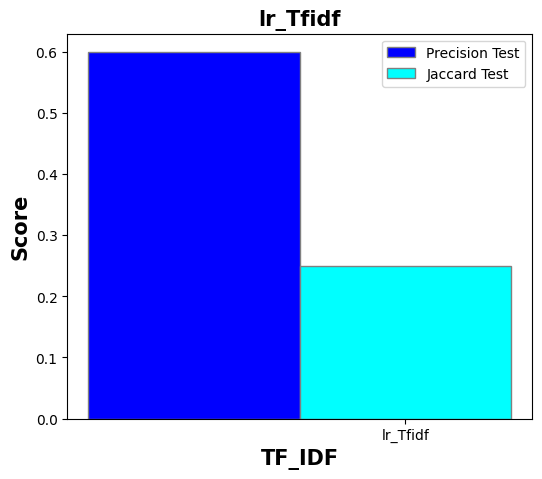

In [116]:
plot_result(result_lr_tfidf)

In [117]:
mlflow.end_run()

### Random Forest

In [118]:
mlflow.start_run()
rf_tfidf = create_random_forest_pipeline()
# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans = rf_tfidf["tfidf"].fit_transform(X_train_sample_str)
X_test_sample_trans = rf_tfidf["tfidf"].transform(X_test_sample_str)
rf_tfidf.fit(X_train_sample_str, y_train_sample_trans)

Pipeline(steps=[('tfidf', CustomTfidfVectorizer()),
                ('RandomForest', RandomForestClassifier(random_state=42))])

In [119]:
predictions = rf_tfidf.predict(X_test_sample_str)

In [120]:
probabilities = predictions
# Définir un seuil personnalisé pour sélectionner les tags
threshold = 0.15  # baisser le seuil pour inclure plus de tags

# Utiliser la fonction pour obtenir les tags prédits
rf_binary_predictions = select_top_n_tags(probabilities, threshold, top_n=5)

In [121]:
print("Precision:", precision_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
rf_predictions_labels =mlb.inverse_transform(rf_binary_predictions)
print(y_test_sample[:5])
# Afficher les labels des prédictions
for labels in rf_predictions_labels:
    print(labels)


Precision: 0.4
Recall: 0.17833333333333332
F1 Score: 0.22333333333333333
10229    [javascript, jquery, inheritance, prototypal-i...
4932     [javascript, asp.net-mvc, json, asp.net-mvc-4,...
6712     [python, django, google-app-engine, web-applic...
29503      [javascript, html, angularjs, validation, grid]
3643     [android, android-widget, android-5.0-lollipop...
Name: Tags, dtype: object
('javascript',)
('javascript',)
()
()
()
()
()
()
('python',)
('sql-server',)


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,Jaccard Test,Fit Time,predict_time
0,rf_Tfidf,0.4,0.178333,None,None


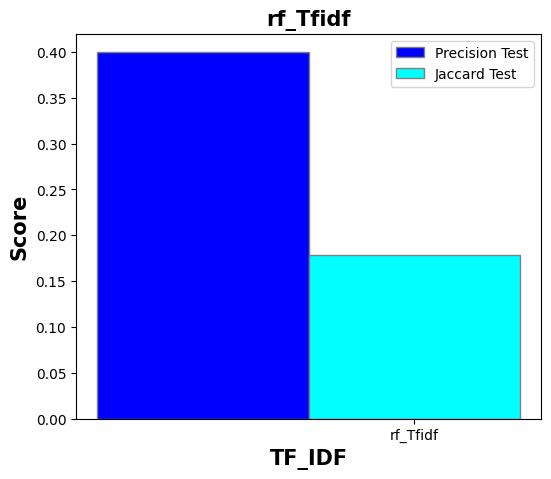

In [122]:
result_rf_tfidf = stocker_results(name="rf_Tfidf",precision_test=precision_score(y_test_sample_trans, rf_binary_predictions,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, rf_binary_predictions, average='samples'),
                                recall_test = recall_score(y_test_sample_trans, rf_binary_predictions, average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, rf_binary_predictions, average='samples'))

plot_result(result_rf_tfidf)


In [123]:
mlflow.end_run()

## Embedding avec word2Vec

In [124]:
pipeline_w2v = create_word2vec_pipeline()
# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans_w2v = pipeline_w2v['word2vec'].fit_transform(X_train_sample_str)
X_test_sample_trans_w2v = pipeline_w2v['word2vec'].transform(X_test_sample_str)

mlb2 = MultiLabelBinarizer()
y_train_sample_trans = mlb2.fit_transform(y_train_sample)

In [125]:
print(X_train_sample_trans_w2v.shape)
print(X_test_sample_trans_w2v.shape)

(200, 400)
(10, 400)


In [126]:
lr_w2v = pipeline_w2v.named_steps['clf_w2v'].fit(X_train_sample_trans_w2v, y_train_sample_trans)
print(lr_w2v)
predictions_w2v = lr_w2v.predict_proba(X_test_sample_trans_w2v)
print("shape de prediction",predictions_w2v.shape)
print("shape de X_test_sample_trans",X_test_sample_trans_w2v.shape)



OneVsRestClassifier(estimator=LogisticRegression())
shape de prediction (10, 525)
shape de X_test_sample_trans (10, 400)


,Vectorizer,precision Test,Jaccard Test,Fit Time,predict_time
0,lr_w2v,0.17,0.111071,None,None


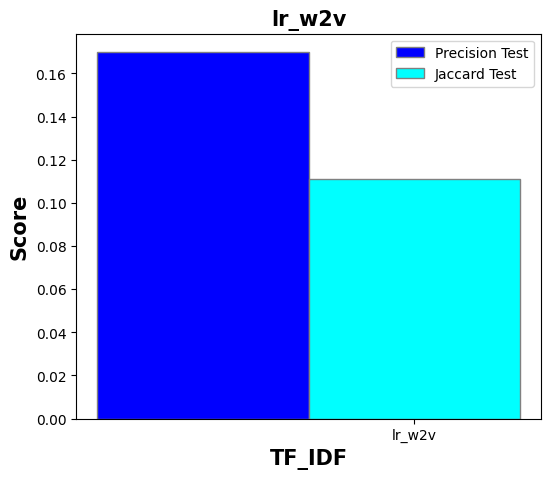

In [127]:
probabilities = predictions_w2v
# Définir un seuil personnalisé pour sélectionner les tags
threshold = 0.1  # baisser le seuil pour inclure plus de tags

# Utiliser la fonction pour obtenir les tags prédits
rf_w2v_binary_predictions = select_top_n_tags(probabilities, threshold, top_n=5)

result_lr_w2f = stocker_results(name="lr_w2v",precision_test=precision_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                recall_test = recall_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))

plot_result(result_lr_w2f)

In [128]:
print("Precision:", precision_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))

Precision: 0.16999999999999998
Recall: 0.225
F1 Score: 0.19126984126984128


In [129]:
# Afficher les labels des prédictions
predictions_labels =mlb.inverse_transform(rf_w2v_binary_predictions)
print(predictions_labels)
print(y_test_sample[:5])


[('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript', 'python'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript'), ('android', 'c#', 'java', 'javascript')]
10229    [javascript, jquery, inheritance, prototypal-i...
4932     [javascript, asp.net-mvc, json, asp.net-mvc-4,...
6712     [python, django, google-app-engine, web-applic...
29503      [javascript, html, angularjs, validation, grid]
3643     [android, android-widget, android-5.0-lollipop...
Name: Tags, dtype: object


In [130]:
mlflow.end_run()

### BERT Embedding

"Bidirectional Encoder Representations from Transformers":  

BERT est un modèle de langage bidirectionnel basé sur des transformers, capable de capturer les relations complexes entre les mots en utilisant le contexte gauche-droite et droite-gauche pour générer des embeddings riches en informations pour chaque mot.

In [133]:
pipeline_bert = create_bert_pipeline()

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans_bert = pipeline_bert['bert_vectorizer'].fit_transform(X_train_sample_str)
X_test_sample_trans_bert = pipeline_bert['bert_vectorizer'].transform(X_test_sample_str)
 
mlb3 = MultiLabelBinarizer()
y_train_sample_trans = mlb3.fit_transform(y_train_sample)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [134]:
lr_bert = pipeline_bert.named_steps['clf_bert'].fit(X_train_sample_trans_bert, y_train_sample_trans)
print(lr_bert)
predictions_bert = lr_bert.predict_proba(X_test_sample_trans_bert)

binary_pred_bert =select_top_n_tags(probabilities, threshold, top_n=5)
print("Precision:", precision_score(y_test_sample_trans, binary_pred_bert, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, binary_pred_bert, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, binary_pred_bert, average='samples'))


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))
Precision: 0.16999999999999998
Recall: 0.225
F1 Score: 0.19126984126984128


,Vectorizer,precision Test,Jaccard Test,Fit Time,predict_time
0,lr_bert,0.17,0.111071,None,None


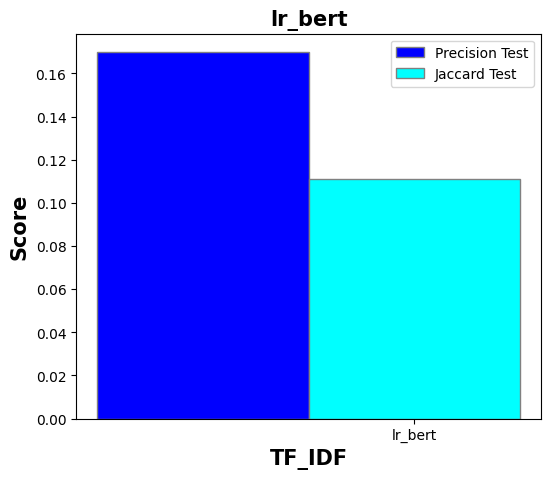

In [135]:
result_lr_bert = stocker_results(name="lr_bert",precision_test=precision_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                recall_test = recall_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, binary_pred_bert, average='samples'))

plot_result(result_lr_bert)

## USE embbedding

In [136]:
pipeline_use = create_use_pipeline()
# Convertir les listes en chaînes de caractères
X_train_sample_str = [' '.join(text) for text in X_train_sample]
X_test_sample_str = [' '.join(text) for text in X_test_sample]

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans_use = pipeline_use['use_vectorizer'].fit_transform(X_train_sample_str)
X_test_sample_trans_use = pipeline_use['use_vectorizer'].transform(X_test_sample_str)
 
mlb4 = MultiLabelBinarizer()
y_train_sample_trans = mlb4.fit_transform(y_train_sample)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [137]:
lr_use = pipeline_use.named_steps['clf_use'].fit(X_train_sample_trans_use, y_train_sample_trans)
print(lr_use)
predictions_use = lr_use.predict_proba(X_test_sample_trans_use)
print("shape de prediction",predictions_use.shape)
print("shape de X_test_sample_trans",X_test_sample_trans_use.shape)

binary_pred_use =select_top_n_tags(probabilities, threshold=0.1, top_n=5)
print("Precision:", precision_score(y_test_sample_trans, binary_pred_use, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, binary_pred_use, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, binary_pred_use, average='samples'))

OneVsRestClassifier(estimator=LogisticRegression(C=1, max_iter=1000))
shape de prediction (10, 525)
shape de X_test_sample_trans (10, 384)
Precision: 0.16999999999999998
Recall: 0.225
F1 Score: 0.19126984126984128
